# Monte Carlo Simulation of Atomic Decay
## Oliver Chapman
### 01/05/2018

This script models a nuclear physics experiment:
 - A beam of unstable nuclei travels in the z direction at 2000 m/s,
 - The nuclei decay with a mean lifetime of 520 $ \mu s$ producing a gamma ray,
 - The nuclei are emitted isotropically in a spherical distribution.
 
A detector array is set up perpendicular to the beam 2 m from the injection point with a resolution of 10 cm in x and 30 cm in y.

<p><img src="https://raw.githubusercontent.com/ochapman-code/montecarlo/master/diagram.png" width="50%" > </p>

This simulation calculates the distribution of gamma rays detected in the experiment using multiple Monte Carlo samples and applies a Gaussian smearing to the resulting output at the detector.

Spherical coordinates are defined using the standard mathematical conventions. These are depicted well on wikipedia:

<p><a href="https://commons.wikimedia.org/wiki/File:3D_Spherical_2.svg#/media/File:3D_Spherical_2.svg"><img src="https://upload.wikimedia.org/wikipedia/commons/d/dc/3D_Spherical_2.svg" alt="3D Spherical 2.svg" width="33%" ></a><br>By &lt;a href="//commons.wikimedia.org/wiki/User:Dmcq" title="User:Dmcq"&gt;Dmcq&lt;/a&gt; - &lt;span class="int-own-work" lang="en"&gt;Own work&lt;/span&gt;, <a href="https://creativecommons.org/licenses/by-sa/3.0" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=18913446">Link</a></p>

### 1) Import libraries

In [1]:
import scipy as sp
import matplotlib.pyplot as plt

### 2) Define uniform distribition function

In [2]:
# This function creates a uniform random distribution between a and b

def rand(a, b):
        return (b-a) * sp.random.random() + a

### 3) Monte Carlo

In [3]:
# Run Monte Carlo simulation with N samples

N = 10000      # The number of Monte Carlo samples run
w, h = 2, 2    # The height and width of the detector
delta = 1.04   # The decay constant for the radioactive decay
x, y, phi_array = [], [], []

for n in range(N):
    
    # Randomly calculate the distance where decay occurs releasing a gamma particle (photon)
    d_z = -delta * sp.log(1 - rand(0, 1))
    
    # The sample is rejected if the decay occurs after reaching the detector (at 2m)
    if d_z >= 2:
        continue
        
    # Randomly generate the spherical direction of gamma particle emission (see diagram above)
    phi = sp.arccos(rand(-1, 1))    # Generates sinusoidal distribution between 0 and pi - see graph below
    theta = rand(0, 1) * 2 * sp.pi      # Generates a uniform distribution between 0 and 2 pi
    
    # Store values of theta to show the distribution in 3.2
    phi_array.append(phi)   

    # Select only particles travelling forwards towards the detector (i.e. in upper hemisphere)
    # Reject if travelling away from the detector
    if sp.cos(phi) >= sp.pi / 2:
        continue
        
    # Calculate the distance to the detector in x, y, and z directions from decay position
    p_z = 2 - d_z
    p = p_z / sp.cos(phi)
    p_x = p * sp.sin(phi) * sp.cos(theta)
    p_y = p * sp.sin(phi) * sp.sin(theta)

    # Store the position when particles collide with the detector
    if (abs(p_x) < w / 2) and (abs(p_y) < h / 2):
        x.append(p_x)
        y.append(p_y)
            
print(N, "Monte Carlo samples run")
print(len(x), "samples successfully recorded by the detector")

10000 Monte Carlo samples run
2543 samples successfully recorded by the detector


### 3.1) Picking points on the sphere

The graph below shows that the random variable $\varphi$ has a sinusoidal distribution. This is required to randomly pick points on the sphere.

See: https://mathworld.wolfram.com/SpherePointPicking.html

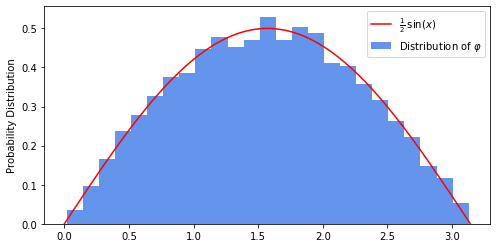

In [4]:
plt.figure(figsize=(8,4))

# Create a normalised sinusoidal probability distribution:
distr_x = sp.arange(0, sp.pi, 0.01)
distr_y = sp.sin(distr_x) / 2
plt.plot(distr_x, distr_y, 'r', label="$\\frac{1}{2} \\: \\sin(x)$", )

# Plot theta's distribution:
plt.hist(phi_array, bins=25, density=True, color='cornflowerblue', label="Distribution of $\\varphi$")

plt.ylabel('Probability Distribution')
plt.legend(loc='upper right')
plt.show()

### 4) Apply Gaussian Smearing

In [5]:
ld = 100

# Create a meshgrid to represent the detector
X = sp.arange(-w/2, w/2, 1/ld)
Y = sp.arange(-h/2, h/2, 1/ld)
xx, yy = sp.meshgrid(X, Y, sparse=True)

# Detector resoultion in x and y
sd_x, sd_y = 0.1, 0.3

# The distribution of gamma rays on the detector is given by Z
Z = sp.zeros([len(Y), len(X)])

for i in range(len(x)):
    
    # Calculate the components of a 2D Gaussian
    x_comp = (xx - x[i]) ** 2 / (2 * sd_x ** 2)
    y_comp = (yy - y[i]) ** 2 / (2 * sd_y ** 2)
    
    # Add the contribution of each collision from the Monte Carlo simulation
    Z += sp.exp(- x_comp - y_comp)  

# Normalise the result
Z = Z / ((2 * sp.pi * sd_x * sd_y) * len(x))

### 5) Plot the results

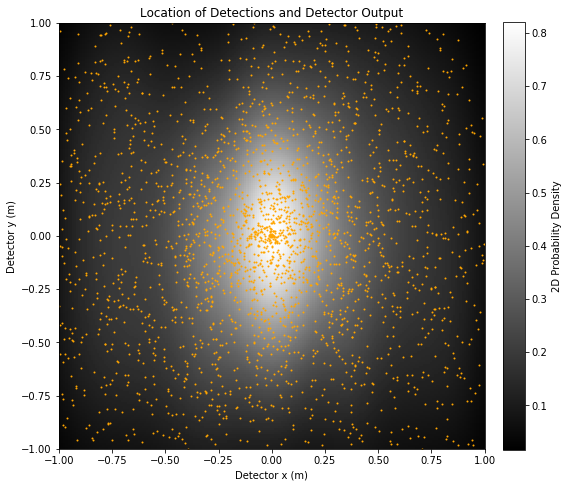

In [6]:
plt.figure(figsize=(8, 8))

plt.imshow(Z, origin='lower', extent=[-w/2,w/2,-h/2,h/2], cmap=plt.get_cmap("gist_gray"))

plt.colorbar(fraction=0.046, pad=0.04, label="2D Probability Density")
plt.scatter(x,y, s=1, color='orange')

plt.ylim(ymin=-h/2, ymax=h/2)
plt.xlim(xmin=-w/2, xmax=w/2)

plt.title("Location of Detections and Detector Output")
plt.xlabel("Detector x (m)")
plt.ylabel("Detector y (m)")

plt.tight_layout()
plt.show()